# $\S$ 2.3. Two Simple Approaches to Prediction: Least Squares and Nearest Neighbors


The ultimate goal of this notebook is to quote definitions and important explanations and to reproduce data and figures represented in *The Elements of Statistical Learning 2E by Hastie et al*. Specifically, it covers *Section 2.3. Two Simple Approaches to Prediction: Least Squares and Nearest Neighbors*.

For introductorial purpose, no third-party algorithms (e.g., scikit-learn) are used here. Also KNN is computed in a bruteforce and unoptimized way, therefore the performance will be quite low.

Author: Don Kim (dgkimdev@gmail.com)

## $\S$ 2.3.3 From Least Squares to Nearest Neighbors

The linear decision boundary from least squares is very smooth, and apparently stable to fit. It does appear to rely heavily on the assumption that a linear decision boundary is appropriate. In language we will develop shortly, it has low variance and potentially high bias.

On the other hand, the $k$-nearest-neighbor procedures do not appear to rely on any stringent assumptions about the underlying data, and can adapt to any situation. However, any particular subregion of the decision boundary depends on a handful of input points and their particular positions, and is thus wiggly and unstable—high variance and low bias.

Let's expose the oracle first! The data is generated with following steps:
1. Generate 10 means $m_k$ from a bivariate Gaussian for each class
\begin{equation}
m_k \sim \begin{cases}
N((1,0)^T, \mathbf{I}) \text{ for BLUE},\\
N((0,1)^T, \mathbf{I}) \text{ for ORANGE}
\end{cases}
\end{equation}
2. For each class, we generate 100 observations as follows:
  1. Pick an $m_k$ at random with probability 1/10
  2. Generate $x_i \sim N(m_k, \mathbf{I}/5)$ 

In [1]:
"""Least Squares and Nearest Neighbors

The ultimate goal of this notebook is to reproduce data and figures
represented in *The Elements of Statistical Learning 2E by Hastie et al*.
Specifically, it covers *Section 2.3. Two Simple Approaches to Prediction:
Least Squares and Nearest Neighbors*.

For introductorial purpose, no third-party algorithms (e.g., scikit-learn)
are used here. Also KNN is computed in a bruteforce way, therefore the
performance will be quite low.

Author: Don Kim (dgkimdev@gmail.com)
"""
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parameters for mean distributions
mean_blue = [1, 0]
mean_orange = [0, 1]
mean_cov = np.eye(2)
mean_size = 10

# Additional parameters for blue and orange distributions
sample_cov = np.eye(2)/5
sample_size = 100

In [3]:
# Generate mean components for blue and orange (10 means for each)
sample_blue_mean = np.random.multivariate_normal(mean_blue, mean_cov, mean_size)
sample_orange_mean = np.random.multivariate_normal(mean_orange, mean_cov, mean_size)

In [4]:
# Generate blue points
sample_blue = np.array([
    np.random.multivariate_normal(sample_blue_mean[random.randint(0, 9)],
                                  sample_cov)
    for _ in range(sample_size)
])
y_blue = [0 for _ in range(sample_size)]

# Generate orange points
sample_orange = np.array([
    np.random.multivariate_normal(sample_orange_mean[random.randint(0, 9)],
                                  sample_cov)
    for _ in range(sample_size)
])
y_orange = [1 for _ in range(sample_size)]

data_x = np.concatenate((sample_blue, sample_orange), axis=0)

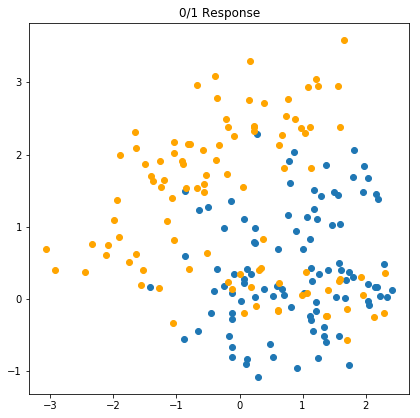

In [5]:
# Plot
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2, 2, 1)

ax1.plot(sample_blue[:, 0], sample_blue[:, 1], 'o')
ax1.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')
ax1.set_title('0/1 Response')
plt.show()

plot_x_min, plot_x_max = ax1.get_xlim()
plot_y_min, plot_y_max = ax1.get_ylim()

## $\S$ 2.3.1. Linear Models and Least Squares

### Linear Models

Given a vector of inputs $X^T = (X_1, \cdots, X_p)$, we predict the output $Y$ via the model
\begin{equation}
\hat{Y} = \hat{\beta}_0 + \sum^p_{j=1}X_j\hat{\beta}_j = X^T\hat{\beta},
\end{equation}
where the constant variable 1 in $X^T = (1, X_1, \cdots, X_p)$ and $\hat{\beta}^T = (\beta_0, \beta_1, \cdots, \beta_p)$.

Viewed as a function over the $p$-dimensional input space,
\begin{equation}
f(X) = X^T\beta
\end{equation}
is linear, and the gradient $f`(X) = \beta$ is a vector in input space that points in the steepest uphill direction.

### How to fit the model: Least Squares

Least Squares pick the coefficients $\beta$ to minimize the residual sum of squares
\begin{equation}
RSS(\beta) = \sum^N_{i=1}(y_i - x_i^T\beta)^2 = (\mathbf{y} - \mathbf{X}\beta)^T(\mathbf{y} - \mathbf{X}\beta),
\end{equation}
where $\mathbf{X}\in\mathbb{R}^{N\times p}$ with each row an input vector, and $\mathbf{y}\in\mathbb{R}^N$.

$RSS(\beta)$ is a quadratic function of the parameters, and hence its minimum always exists, but may not be unique.

Differentiating w.r.t. $\beta$ we get the *normal equations*
\begin{equation}
\hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y},
\end{equation}
and the *fitted value* at the $i$th input $x_i$ is 
\begin{equation}
\hat{y}_i = \hat{y}(x_i) = x_i^T\hat{\beta}.
\end{equation}

In [6]:
# Linear regression
mat_x = np.hstack((np.ones((sample_size*2, 1)), data_x))
mat_xt = np.transpose(mat_x)
vec_y = np.concatenate((y_blue, y_orange), axis=0)

# Solve (X^T*X)b = X^T*y for b
ols_beta = np.linalg.solve(np.matmul(mat_xt, mat_x), np.matmul(mat_xt, vec_y))

print('=== Estimated Coefficients for OLS ===')
print('beta0:', ols_beta[0], '(constant)')
print('beta1:', ols_beta[1])
print('beta2:', ols_beta[2])

=== Estimated Coefficients for OLS ===
beta0: 0.392833293083 (constant)
beta1: -0.147395237781
beta2: 0.183258362209


The fitted value $\hat{Y}$ are converted to a fitted class variable $\hat{G}$ according to the rule
\begin{equation}
\hat{G} = \begin{cases}
1 \text{ (ORANGE) if } \hat{Y} \gt 0.5,\\
0 \text{ (BLUE) if } \hat{Y} \le 0.5.
\end{cases}
\end{equation}
And the two predicted classes are separated by the *decision boundary* $\{x: x^T\hat{\beta} = 0.5\}$, which in linear.

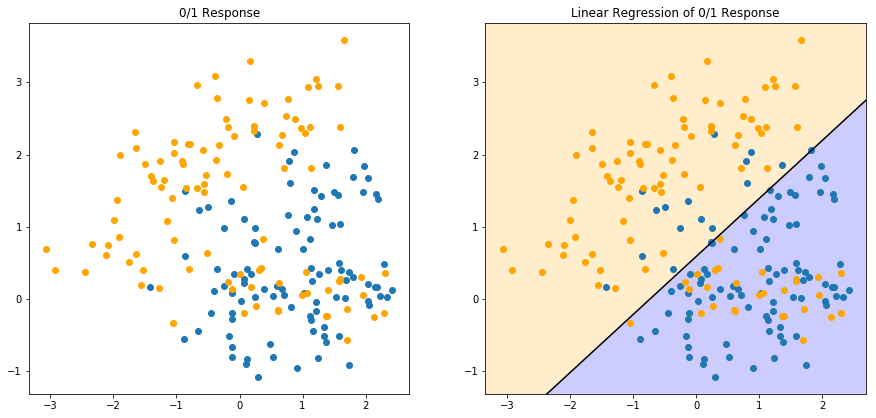

In [7]:
# Plot for OLS
ax2 = fig.add_subplot(2, 2, 2)

ax2.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax2.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')

# OLS line for y_hat = 0.5
ols_line_y_min = (.5 - ols_beta[0] - plot_x_min*ols_beta[1])/ols_beta[2]
ols_line_y_max = (.5 - ols_beta[0] - plot_x_max*ols_beta[1])/ols_beta[2]
ax2.plot([plot_x_min, plot_x_max], [ols_line_y_min, ols_line_y_max], color='black')

# https://matplotlib.org/examples/pylab_examples/fill_between_demo.html
ax2.fill_between([plot_x_min, plot_x_max], plot_y_min, [ols_line_y_min, ols_line_y_max],
                facecolor='blue', alpha=.2)
ax2.fill_between([plot_x_min, plot_x_max], [ols_line_y_min, ols_line_y_max], plot_y_max,
                facecolor='orange', alpha=.2)
ax2.set_title('Linear Regression of 0/1 Response')
ax2.set_xlim((plot_x_min, plot_x_max))
ax2.set_ylim((plot_y_min, plot_y_max))
fig

## $\S$ 2.3.2 Nearest-Neighbor Methods

The $k$-nearest neighbor fit for $\hat{Y}$ finds the $k$ observations with $x_i$ closest to $x$ in input space, and average their responses. The formal definition is as follows:
\begin{equation}
\hat{Y}(x) = \frac{1}{k}\sum_{x_i\in N_k(x)} y_i,
\end{equation}
where $N_k(x)$ is the neighborhood of $x$ defined by the $k$ closest points $x_i$ in the training sample.

It appears that $k$-nearest-neighbor fits have a single parameter, the number of neighbors $k$, compared to the $p$ parameters in least-squares fits. Although this is the case, we will see that the *effective* number of parameters of $k$-nearest neighbors is $N/k$ and is generally bigger than $p$, and decreases with increasing $k$. To get an idea of why, note that if the neighborhoods were nonoverlapping, there would be $N/k$ neighborhoods and we would fit one parameter (a mean) in each neighborhood.

It is clear that we cannot use sum-of-squared errors on the training set as a criterion for picking $k$, since we would always pick $k = 1$!

In [8]:
# K-nearest neighbors
def knn(k: int, point, data_x, data_y) -> float:
    if not isinstance(point, np.ndarray):
        point = np.array(point)
    distances = [(sum((x - point)**2), y) for x, y in zip(data_x, data_y)]
    distances.sort()
    return sum(y for _, y in distances[:k])/k

In [9]:
# Compute KNN for k = 15 and k = 1
knn_grid = np.array([(i, j)
                     for i in np.arange(plot_x_min, plot_x_max, .1)
                     for j in np.arange(plot_y_min, plot_y_max, .1)])
knn15_result = np.array([
    (i, j, knn(15, (i, j), data_x, vec_y))
    for i, j in knn_grid
])
knn1_result = np.array([
    (i, j, knn(1, (i, j), data_x, vec_y))
    for i, j in knn_grid
])

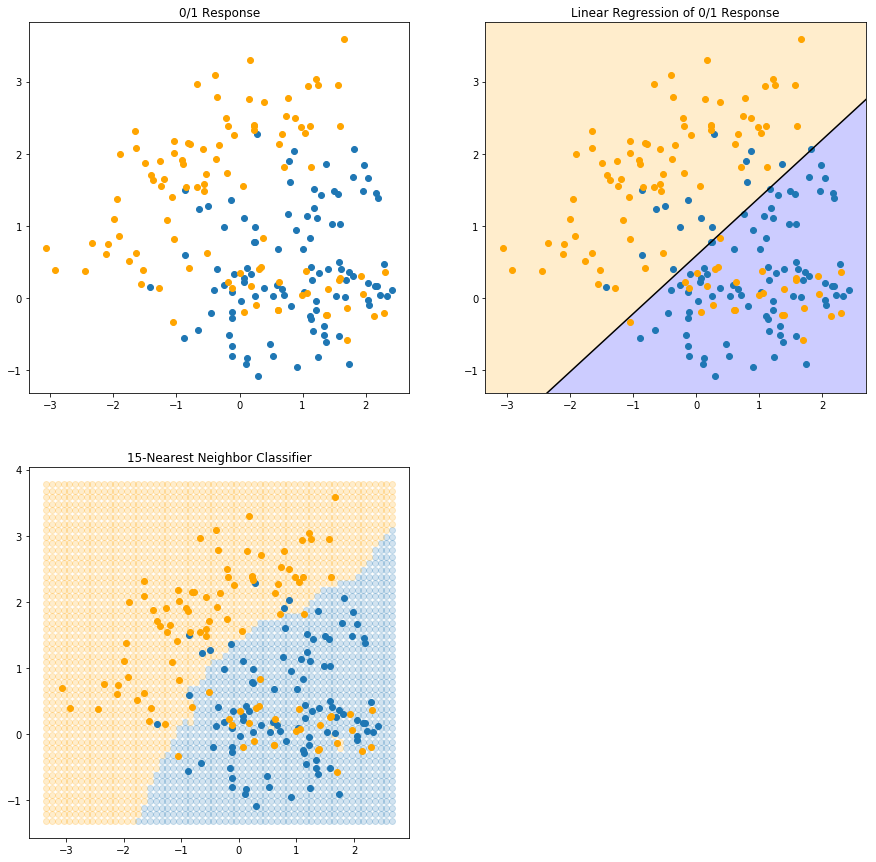

In [10]:
# Plot for KNN with k = 15
knn15_blue = np.array([
    (i, j)
    for i, j, knn15 in knn15_result
    if knn15 < .5
])
knn15_orange = np.array([
    (i, j)
    for i, j, knn15 in knn15_result
    if knn15 > .5
])
ax3 = fig.add_subplot(2, 2, 3)
# KNN areas
ax3.plot(knn15_blue[:, 0], knn15_blue[:, 1], 'o', alpha=.2)
ax3.plot(knn15_orange[:, 0], knn15_orange[:, 1], 'o', color='orange', alpha=.2)
# Original data
ax3.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax3.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')
ax3.set_title('15-Nearest Neighbor Classifier')
fig

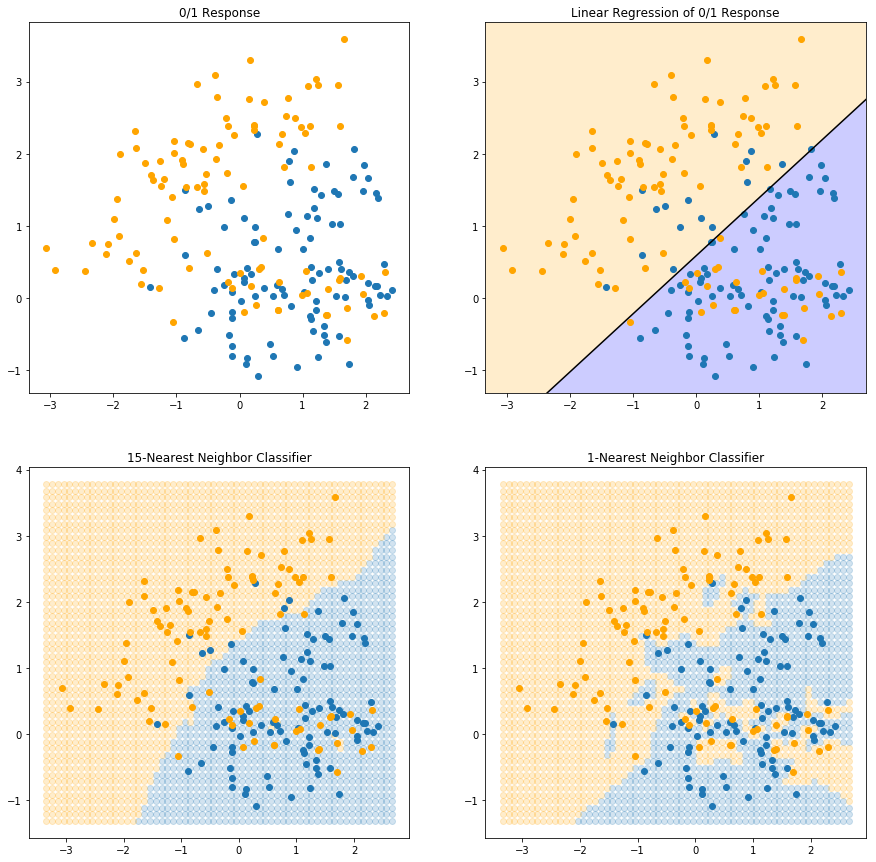

In [11]:
# Plot for KNN with k = 1
knn1_blue = np.array([
    (i, j)
    for i, j, knn1 in knn1_result
    if knn1 < .5
])
knn1_orange = np.array([
    (i, j)
    for i, j, knn1 in knn1_result
    if knn1 > .5
])
ax4 = fig.add_subplot(2, 2, 4)
# KNN areas
ax4.plot(knn1_blue[:, 0], knn1_blue[:, 1], 'o', alpha=.2)
ax4.plot(knn1_orange[:, 0], knn1_orange[:, 1], 'o', color='orange', alpha=.2)
# Original data
ax4.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax4.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')
ax4.set_title('1-Nearest Neighbor Classifier')
fig